# Code : 

https://github.com/shettyprithvi/Toxic-comment-classification-deep-learning/blob/master/Toxic%20comment%20classification%20-%20Deep%20learning%20vs%20machine%20learning.ipynb

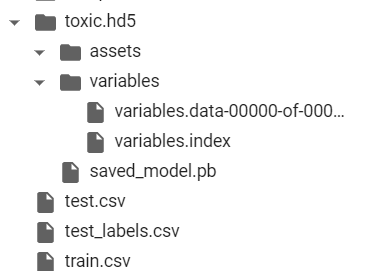

## 1. Data reading and cleaning

### 1.1 Importing essential libraries

In [2]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


### 1.2 Null cleaning function

In [3]:
#Null cleaning function

def myfillna(series):
    if series.dtype is pd.np.dtype(float):
        return series.fillna('')
    elif series.dtype is pd.np.dtype(int):
        return series.fillna('')
    else:
        return series.fillna('NA')

### 1.3 Reading data and applying null cleaning function

In [4]:
#Reading data
data=pd.read_csv('train.csv',encoding='latin-1')

In [5]:
data.shape

(159571, 8)

In [6]:
data=data.apply(myfillna)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [7]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [8]:
data.comment_text

0         Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27                                                                                                                                                                                                                                                                                                                                                                         
1         D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)                                                                                                                                                                                                                                                 

### 1.4 Cleaning all non-alphanumeric characters

In [9]:
data.comment_text=data.comment_text.str.replace('[^a-zA-Z]', ' ')

### 1.5 Converting to lowercase and removing punctuations

In [10]:

RE_PREPROCESS = r'\W+|\d+' #the regular expressions that matches all non-characters
data.comment_text = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in data.comment_text])

#### Cleaned data output

In [11]:
data.comment_text.head()

0    explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now                                                                                                                                                                                                                                                                                                                                                                   
1    d aww he matches this background colour i m seemingly stuck with thanks talk january utc                                                                                                                                                                                                                                                                                                          

In [12]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember what page that s on,0,0,0,0,0,0


## 2. Deep learning using Bidirectional LSTM for prediction

### 2.1 Importing all the keras libraries

In [13]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Activation, Dense, Embedding, Bidirectional
from keras.layers import LSTM
from keras.datasets import imdb
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import AveragePooling1D
from keras.layers import Conv1D
from keras.models import load_model
from keras.preprocessing.text import Tokenizer

### 2.2 Splitting into training and test data

In [14]:
train_size = int(len(data) * .2)
train_posts = data['comment_text'][train_size:]
train_tags = data['toxic'][train_size:]
test_posts = data['comment_text'][:train_size]
test_tags = data['toxic'][:train_size]

In [15]:
test_posts

0        explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now                                                                                                                                                                                                                                                                                                                                                                   
1        d aww he matches this background colour i m seemingly stuck with thanks talk january utc                                                                                                                                                                                                                                                                                                  

### 2.3 Tokenizer function of keras
**Tokenizer will tokenize the sentences by fitting it on training set with maximum number of features of 3000 and preprocess it using Tf-idf (It will also remove stopwords)**

In [16]:
vocab_size = 3000
tokenize = Tokenizer(num_words=vocab_size)
tokenize.fit_on_texts(train_posts)

### 2.4 Vectorization 
**Convert the tokens into a matrix feature space (vectorized format)**

In [17]:
x_train = tokenize.texts_to_matrix(train_posts)

In [18]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_train.shape

(127657, 1, 3000)

### 2.5 Converting all the output labels into appropriate categorical form for model training

In [19]:
from sklearn.preprocessing import LabelBinarizer

In [20]:
train_tags.shape

(127657,)

In [21]:
train_tags=train_tags.astype(int)
test_tags=test_tags.astype(int)

In [22]:
#Converting the training labels to the binary format
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [23]:
#Converting binary labels to categorical format for Keras model training
from keras.utils import to_categorical
y_train = to_categorical(y_train)

### 2.6 Building the neural network

In [24]:

data_dim = 3000
timesteps = 1
num_classes = 2

model = Sequential()
model.add(Bidirectional(LSTM(30, return_sequences=True,
               input_shape=(timesteps, data_dim))))  # returns a sequence of vectors of dimension 30
model.add(Conv1D(30, 1, activation='relu')) #Convolution Layer for filtering the vectors
model.add(Bidirectional(LSTM(30, return_sequences=True)))
model.add(Bidirectional(LSTM(30,recurrent_dropout=0.1)))  # return a single vector of dimension 30
model.add(Activation('relu')) #Adding a RELU activation unit
model.add(Dense(2, activation='softmax')) #Final softmax layer which will predict the output

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 2.7 Training the model with 30 epochs of the training data

In [25]:
model.fit(x_train, y_train, batch_size = 200, epochs = 30, verbose = 1)

Epoch 1/30
639/639 [==============================] - 49s 53ms/step - loss: 0.2958 - accuracy: 0.9238
Epoch 2/30
639/639 [==============================] - 31s 49ms/step - loss: 0.1107 - accuracy: 0.9611
Epoch 3/30
639/639 [==============================] - 30s 48ms/step - loss: 0.0994 - accuracy: 0.9646
Epoch 4/30
639/639 [==============================] - 32s 50ms/step - loss: 0.0896 - accuracy: 0.9672
Epoch 5/30
639/639 [==============================] - 33s 52ms/step - loss: 0.0807 - accuracy: 0.9709
Epoch 6/30
639/639 [==============================] - 36s 57ms/step - loss: 0.0675 - accuracy: 0.9758
Epoch 7/30
639/639 [==============================] - 38s 59ms/step - loss: 0.0544 - accuracy: 0.9806
Epoch 8/30
639/639 [==============================] - 38s 60ms/step - loss: 0.0438 - accuracy: 0.9844
Epoch 9/30
639/639 [==============================] - 32s 49ms/step - loss: 0.0346 - accuracy: 0.9880
Epoch 10/30
639/639 [==============================] - 40s 63ms/step - loss: 0.028

### 2.8 Saving and Loading the model

In [26]:
#Saving the model
model.save('toxic.hd5')

INFO:tensorflow:Assets written to: toxic.hd5/assets


INFO:tensorflow:Assets written to: toxic.hd5/assets


In [27]:
model=load_model('toxic.hd5')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 60)             727440    
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 30)             1830      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 60)             14640     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60)                21840     
_________________________________________________________________
activation (Activation)      (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 122       
Total params: 765,872
Trainable params: 765,872
Non-trainable params: 0
__________________________________________________

### Note: All the classification of the 6 categories (Toxic, Severely toxic, Obscene, Threat, Insult, Hate) have been done by fitting in the model designed above.  Hence, same steps have been followed for each classifier mentioned below.

### 2.8.1 Toxic category classification

In [29]:
#Converting test comments to tokenized form and test labels to categorical labels
x_test=tokenize.texts_to_matrix(test_posts)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
y_test = to_categorical(y_test)
type(test_posts)


pandas.core.series.Series

In [30]:
#Evaluating the test set results
score = model.evaluate(x_test, y_test, batch_size=2000, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

16/16 [==============================] - 4s 90ms/step - loss: 0.3993 - accuracy: 0.9445
Test score: 0.39929282665252686
Test accuracy: 0.9445071220397949


### 2.8.1.1 Test set results

In [31]:
x_test

array([[[0., 1., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 1., ..., 0., 0., 0.]],

       ...,

       [[0., 1., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 1., ..., 0., 0., 0.]]])

In [32]:
for i in range(3):    
    prediction = model.predict(np.array([x_test[i]]))

In [33]:
output=model.predict(x_test).round(0).astype(int)[:,1]

In [34]:
x=pd.DataFrame({'Comment': test_posts, 'Toxic': output})

In [35]:
x

,Comment,Toxic
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,0
1,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,0
2,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0
3,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport,0
4,you sir are my hero any chance you remember what page that s on,0
...,...,...
31909,december utc i think it s essential that a proof of these lost works is done where does it say that they did in fact exist at some point apparently there is a listing but where can i go to see this listing,0
31910,unblock an administrator at ani has expressed her reasons why my block was inappropriate here please take a minute to see that i was unjustly blocked for doing something wikipedia allows me to do,0
31911,i am modifying the sentence to the saint thomas christians believed to be founded by the apostle thomas,0
31912,hey dipshit i made a contribution wooden ships so now i can make vandalizations after that i ll make another contribution cumfart with a picture of you lololol so i can make even more vandalisiziations,0


In [36]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Predictions on personal ds

In [37]:
s =pd.DataFrame([["hellow aamzimg ppl"],["hey bitch guess what koschecks fighting at ufc you know waht that means so give your adress so i could make u suck my cock"],["way to be racist asshole	"]])
test_posts = s[0][:]
test_posts


0    hellow aamzimg ppl                                                                                                        
1    hey bitch guess what koschecks fighting at ufc you know waht that means so give your adress so i could make u suck my cock
2    way to be racist asshole\t                                                                                                
Name: 0, dtype: object

In [44]:
#Converting test comments to tokenized form and test labels to categorical labels
x_test=tokenize.texts_to_matrix(test_posts)
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))


In [45]:
for i in range(3):    
    prediction = model.predict(np.array([x_test[i]]))

In [46]:
output=model.predict(x_test).round(0).astype(int)[:,1]

In [47]:
x=pd.DataFrame({'Comment': test_posts, 'Toxic': output})

output

array([0, 1, 1])